In [1]:
# Settings
#filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
filename    = '/home/axel/PycharmProjects/pax/Kr83m_tpc_gaseous_lutz_150522_coin1_th300_6.hdf5'
file_format = 'hfd5'
#loglevel    = 'DEBUG'

In [2]:
import NotebookLoader
import Function_definitions as fn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
import h5py
import units
from recarray_tools import append_fields

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

importing IPython notebook from Function_definitions.ipynb


/home/axel/anaconda3-2.2/lib/python3.4/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


In [3]:
# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
import h5py
f = h5py.File(filename)
events = f.get('Event')[:]
peaks = f.get('Peak')[:]
f.keys()
f.close()
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")

In [4]:
# Append fields to the event and peak list. Only the ones that can be directly determined from the events lists
# full range: the total time of the peak.
peaks = append_fields(peaks, 'full_width', (peaks['right'] - peaks['left'] + 1)*fn.dt)
peaks = append_fields(peaks,'mid',peaks['left']*fn.dt + 0.5* peaks['full_width'])

# Recalculate area fraction top because of wrong ordering of PMTs
peaks['area_fraction_top'] = peaks['area_per_channel'][:,3] / peaks['area']
two_peaks_events = (events['n_peaks'] == 2)

In [5]:
peaks_per_event = fn.group_by(peaks, 'Event')
peak_types = [b's1', b's2', b'unknown', b'noise', b'lone_pulse']
for pt in peak_types:
    events = append_fields(events,'n_'+pt.decode(),np.array([len(x[x['type'] == pt]) for x in peaks_per_event]))
# Add number of BIG peaks (mainly S2 is important). Use to cut pileup / double scatters    
    events = append_fields(events,'n_big_'+pt.decode(),np.array([len(x[(x['type'] == pt) & (x['area'] >= 100)]) for x in peaks_per_event]))


In [6]:
n_before = len(events)
cut = (events['n_s1'] == 2)
events = events[cut]
peaks_per_event = [x for i, x in enumerate(peaks_per_event) if cut[i]]
len(peaks_per_event[0])

2

In [17]:
len(peaks_per_event)

2881

In [8]:
time_differences = []
first_peaks = []
second_peaks = []
for peakdoublet in peaks_per_event:
    first, last = (peakdoublet[0], peakdoublet[1]) if (peakdoublet[0]['hit_time_mean'] < peakdoublet[1]['hit_time_mean']) else (peakdoublet[1], peakdoublet[0])
    first_peaks.append(first)
    second_peaks.append(last)
    if (first['area'] > last['area']):
        time_differences.append(first['hit_time_mean']-last['hit_time_mean'] )

time_differences = [abs(x) for x in time_differences]

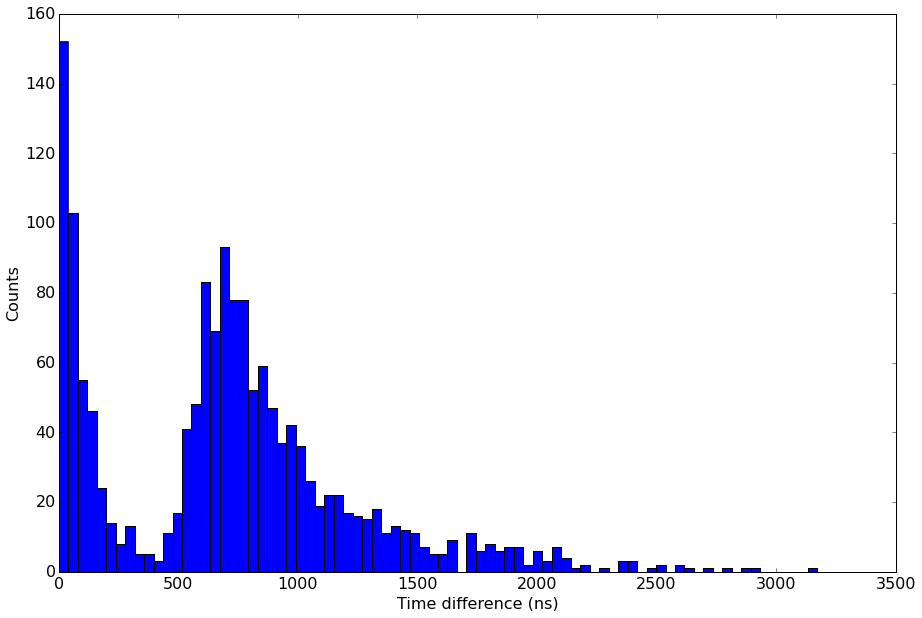

In [11]:
plt.figure(figsize=(15,10))
plt.hist(time_differences, bins = 80)
plt.xlabel('Time difference (ns)')
plt.ylabel('Counts')
plt.show()

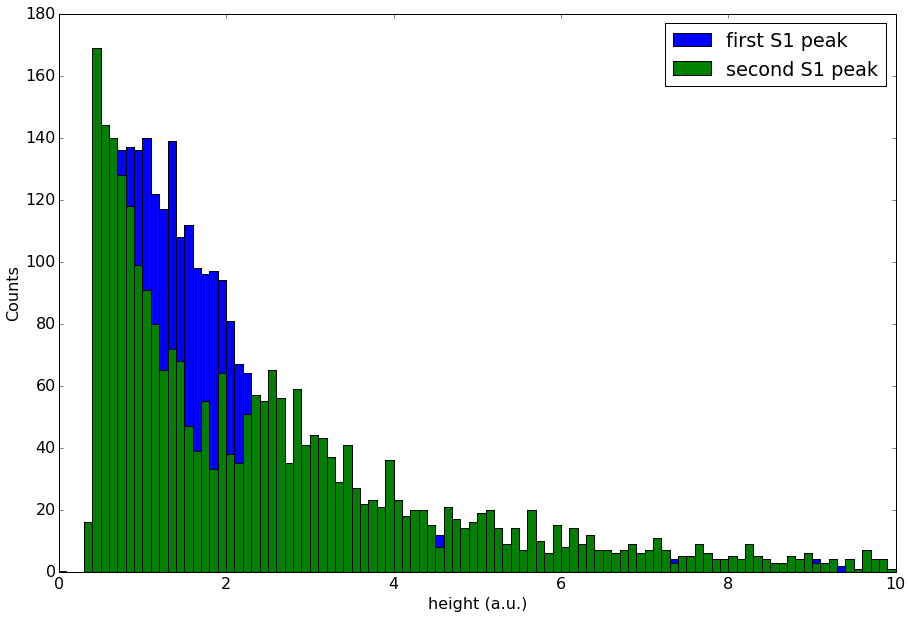

In [14]:
plt.figure(figsize=(15,10))
n_bins = 100
plt.hist([firsts['height'] for firsts in first_peaks], bins = n_bins, range=(0,10), label="first S1 peak")
plt.hist([lasts['height'] for lasts in second_peaks], bins = n_bins, range=(0,10), label = "second S1 peak")
plt.xlabel('height (a.u.)')
plt.ylabel('Counts')
plt.legend()
plt.show()

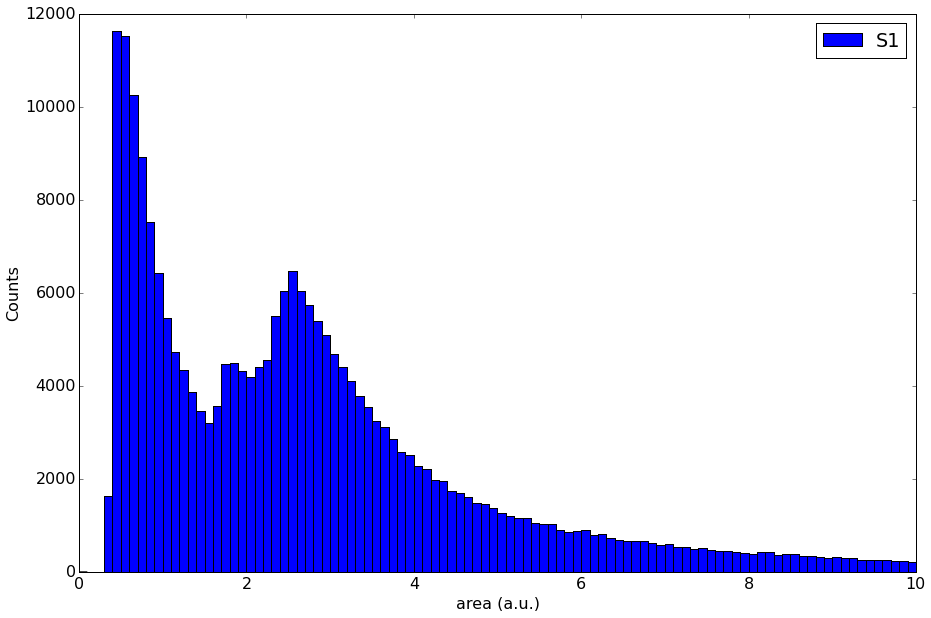

In [19]:
plt.figure(figsize=(15,10))
n_bins = 100
plt.hist([firsts['height'] for firsts in peaks], bins = n_bins, range=(0,10), label="S1")
plt.xlabel('area (a.u.)')
plt.ylabel('Counts')
plt.legend()
plt.show()